In [1]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.mllib.feature import Word2Vec
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils

from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import PipelineModel

# Reading Data
The first challenge is to read in the training dataset, which is composed of 25,000 positive and negative movie reviews. The following lines of code will read in these files and then create our binary labels of 0 for a negative review and 1 for a positive review.

In [2]:
# import training data
negativeReviewsTraining = sqlContext.read.text("aclImdb/train/neg/*.txt").toDF("reviewText")
positiveReviewsTraining = sqlContext.read.text("aclImdb/train/pos/*.txt").toDF("reviewText")

# import test data
negativeReviewsTest = sqlContext.read.text("aclImdb/test/neg/*.txt").toDF("reviewText")
positiveReviewsTest = sqlContext.read.text("aclImdb/test/pos/*.txt").toDF("reviewText")

In [3]:
# we label create labels for our training set
posTraining = positiveReviewsTraining.withColumn("label", lit(1.0))
negTraining = negativeReviewsTraining.withColumn("label", lit(0.0))

# we label create labels for our test set
posTesting = positiveReviewsTest.withColumn("label", lit(1.0))
negTesting = negativeReviewsTest.withColumn("label", lit(0.0))

In [4]:
# we merge the postive and negative reviews 
movieReviewsTraining = posTraining.union(negTraining).withColumn("row_id",monotonically_increasing_id())
movieReviewsTest = posTesting.union(negTesting).withColumn("row_id",monotonically_increasing_id())

In [5]:
print((movieReviewsTest.count(), len(movieReviewsTest.columns)))

(25000, 3)


# Data Cleaning
We regularize tokens to a common representation
1. The code below will lowercase all words 
2. Remove punctuation symbols with a regular expression function
3. Remove stopwords. These are essentially injunctions and conjunctions such as in, at, the, and, etc, and so on, that add no contextual meaning to the review that we want to classify

In [6]:
# cleaning training DataFrame
cleanTrainingDF = movieReviewsTraining.select('row_id','label', (lower(regexp_replace('reviewText', "[^a-zA-Z\\s]", ""))).alias('reviewText'))
cleanTrainingDF = cleanTrainingDF.select('row_id','label', (regexp_replace(col("reviewText"), "  ", " ")).alias('reviewText'))

# cleaning testing DataFrame
cleanTestDF = movieReviewsTest.select('row_id','label', (lower(regexp_replace('reviewText', "[^a-zA-Z\\s]", ""))).alias('reviewText'))
cleanTestDF = cleanTestDF.select('row_id','label', (regexp_replace(col("reviewText"), "  ", " ")).alias('reviewText'))

In [7]:
cleanTrainingDF.orderBy(rand()).limit(25).show()

+-------------+-----+--------------------+
|       row_id|label|          reviewText|
+-------------+-----+--------------------+
|5291399708701|  0.0| is a film based ...|
| 644245094405|  1.0|while i have a gr...|
|3298534883342|  1.0|what can i say an...|
| 214748364812|  1.0|the first mystery...|
|5626407157773|  0.0|i didnt expect mu...|
|2388001816591|  1.0|this movie was ex...|
|3779571220489|  0.0|nell shipman must...|
|5549097746451|  0.0|sondra locke stin...|
|5832565587972|  0.0|now i wont deny t...|
|5463198400522|  0.0|supposedly a soci...|
|3590592659470|  0.0|thats certainly a...|
|  34359738369|  1.0|neatly skipping o...|
|2740189134868|  1.0|if the screenwrit...|
|6597069766676|  0.0|very disappointin...|
|3143916060679|  1.0|this is one the f...|
|1898375544863|  1.0|why do people bit...|
|2327872274445|  1.0|beside the fact t...|
|4629974745089|  0.0|ive never been im...|
| 111669149714|  1.0|its a funny busin...|
| 541165879325|  1.0|theres a theory o...|
+----------

In [8]:
cleanTestDF.orderBy(rand()).limit(25).show()

+-------------+-----+--------------------+
|       row_id|label|          reviewText|
+-------------+-----+--------------------+
| 412316860444|  1.0|this is a fun mov...|
|6004364279808|  0.0|committed stars h...|
|4767413698577|  0.0|to paraphrase the...|
| 910533066759|  1.0|will smith is smo...|
| 335007449094|  1.0|i actually found ...|
|4552665333768|  0.0|years ago i caugh...|
|3401614098432|  0.0|special sneak pre...|
|2551210573839|  1.0|this was another ...|
|5205500362780|  0.0|this has got to b...|
|1915555414017|  1.0|lets face itbr br...|
|5523327942666|  0.0|thats how i was w...|
|2680059592714|  1.0|i saw this movie ...|
|3298534883347|  1.0|after watching th...|
|2439541424141|  1.0|this film stands ...|
|2937757630477|  1.0|the kid is a real...|
|1005022347295|  1.0|i stumbled upon t...|
|6116033429516|  0.0|br br ive seen th...|
|1219770712084|  1.0|ok i havent read ...|
|3444563771403|  0.0|following the whi...|
|3848290697240|  0.0|if this is whats ...|
+----------

# Configure an ML Pipeline
Now we will transform string representation into a numeric one. We will now use Spark ML to apply a very algorithm called TF-IDF to convert our tokenized reviews into vectors, which will be inputs to our machine learning models. 

We will re-run the code below for numFeatures = 100, 200, 2000, 4000, 10000.

We can generate vectors with different lengths by changing the 'numFeatures' parameter.

In [94]:
# pipeline for transforming training DataFrame
tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(),outputCol="filtered")
cv = HashingTF(inputCol=remover.getOutputCol(), outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol= cv.getOutputCol(), outputCol="tf-idf")
finalTrainingDF = Pipeline(stages=[tokenizer,remover,cv,idf]).fit(cleanTrainingDF).transform(cleanTrainingDF)
trainingDF = finalTrainingDF.select("row_id","label","tf-idf")

In [95]:
trainingDF.show(2)

+------+-----+--------------------+
|row_id|label|              tf-idf|
+------+-----+--------------------+
|     0|  1.0|(10000,[1,40,50,5...|
|     1|  1.0|(10000,[15,25,44,...|
+------+-----+--------------------+
only showing top 2 rows



In [96]:
# pipeline for transforming test Dataframe
tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(),outputCol="filtered")
cv = HashingTF(inputCol=remover.getOutputCol(), outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol= cv.getOutputCol(), outputCol="tf-idf")
finalTestDF = Pipeline(stages=[tokenizer,remover,cv,idf]).fit(cleanTestDF).transform(cleanTestDF)
testDF = finalTestDF.select("row_id","label","tf-idf")

In [97]:
testDF.show(2)

+------+-----+--------------------+
|row_id|label|              tf-idf|
+------+-----+--------------------+
|     0|  1.0|(10000,[1,7,15,56...|
|     1|  1.0|(10000,[12,13,14,...|
+------+-----+--------------------+
only showing top 2 rows



# Logistic Regression

In [98]:
## Create a new LR object for the model
logReg = LogisticRegression( regParam=0.1,threshold=0.5,labelCol = 'label',featuresCol='tf-idf')
## Undertake training and create an LR model
lrModel = Pipeline(stages=[logReg]).fit(trainingDF)

In [99]:
predictions = lrModel.transform(testDF)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.8479450208656284


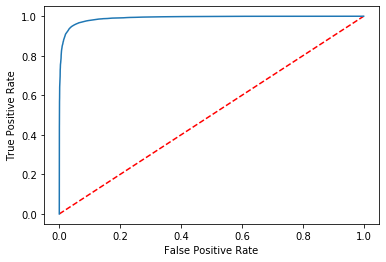

In [100]:
modelSummary = lrModel.stages[-1].summary

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(modelSummary.roc.select('FPR').collect(),
         modelSummary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [101]:
lrModel.stages[-1].summary

# Decision Trees

In [102]:
# hyperparameters: maxDepth, maxBins, minInfoGain, minInstancePerNode
dt = DecisionTreeClassifier(labelCol = 'label',featuresCol='tf-idf')
dtModel = Pipeline(stages=[dt]).fit(trainingDF)

In [103]:
predictions = dtModel.transform(testDF)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.7270571151279948


In [104]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

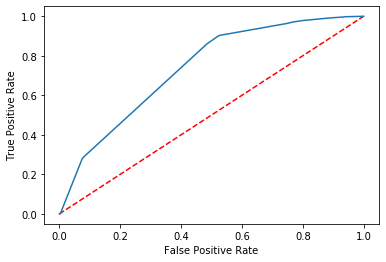

In [105]:
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(x_val, y_val)
plt.show()

# Random forest classifier

In [106]:
from pyspark.ml.classification import GBTClassifier

In [107]:
rf = RandomForestClassifier(labelCol="label", featuresCol="tf-idf",
                            numTrees=100, maxDepth = 8, maxBins = 2)

rfModel = Pipeline(stages=[rf]).fit(trainingDF)


In [108]:
predictions = rfModel.transform(testDF)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.8108617825661187


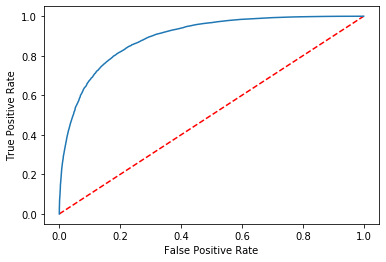

In [109]:
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(x_val, y_val)
plt.show()

# Gradient-boosted tree classifier


In [110]:
gbt = GBTClassifier(labelCol="label", featuresCol="tf-idf", maxIter=10, stepSize=0.01)

gbtModel = Pipeline(stages=[gbt]).fit(trainingDF)

In [111]:
predictions = gbtModel.transform(testDF)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.7274115344350244


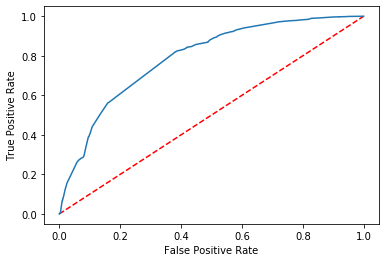

In [112]:
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(x_val, y_val)
plt.show()

# Linear Support Vector Machine

In [113]:
lsvc = LinearSVC(labelCol="label", featuresCol="tf-idf",maxIter=10, regParam=0.1)
lsvcModel = Pipeline(stages=[lsvc]).fit(trainingDF)

In [114]:
predictions = lsvcModel.transform(testDF)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.8549983966265791


# Naive Bayes

In [115]:
nb = NaiveBayes(labelCol="label", featuresCol="tf-idf",smoothing=1.0, modelType="multinomial")
nbModel = Pipeline(stages=[nb]).fit(trainingDF)

In [116]:
predictions = nbModel.transform(testDF)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.8073746940715856


In [117]:
# Saving Models

lrModel.save('Logistic_10000')
dtModel.save('Decsion_tree_10000')
rfModel.save('Random_forest_classifier_10000')
gbtModel.save("Gradient_boosted_tree_10000")
lsvcModel.save("Linear_Support_Vector_Machine_10000")
nbModel.save("Naive_Bayes_10000")


# Additional Metrics

In [87]:
predictionRDD = predictions.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))

In [ ]:
metrics = MulticlassMetrics(predictionRDD)
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()

In [ ]:
metrics = MulticlassMetrics(predictionRDD)


In [ ]:
labels = [0.0, 1.0]
for label in sorted(labels):
    print(metrics.precision(label))
    print(metrics.recall(label))

In [ ]:
f1Score

In [ ]:
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

In [ ]:
print("Area under ROC = %s" % metrics.areaUnderPR)

In [ ]:
metrics.Precision

In [ ]:
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')